In [1]:
import sys

In [2]:
!{sys.executable} -m pip install seaborn joblib "gymnasium[atari]" "gymnasium[accept-rom-license]" matplotlib scikit-image

In [3]:
available = [
 'Adventure',
 'AirRaid',
 'Alien',
 'Amidar',
 'Assault',
 'Asterix',
 'Asteroids',
 'Atlantis',
 'Atlantis2',
 'Backgammon',
 'BankHeist',
 'BasicMath',
 'BattleZone',
 'BeamRider',
 'Berzerk',
 'Blackjack',
 'Bowling',
 'Boxing',
 'Breakout',
 'CMakeLists',
 'Carnival',
 'Casino',
 'Centipede',
 'ChopperCommand',
 'CrazyClimber',
 'Crossbow',
 'DarkChambers',
 'Defender',
 'DemonAttack',
 'DonkeyKong',
 'DoubleDunk',
 'Earthworld',
 'ElevatorAction',
 'Enduro',
 'Entombed',
 'Et',
 'FishingDerby',
 'FlagCapture',
 'Freeway',
 'Frogger',
 'Frostbite',
 'Galaxian',
 'Gopher',
 'Gravitar',
 'Hangman',
 'HauntedHouse',
 'Hero',
 'HumanCannonball',
 'IceHockey',
 'JamesBond',
 'JourneyEscape',
 'Kaboom',
 'Kangaroo',
 'KeystoneKapers',
 'Kingkong',
 'Klax',
 'Koolaid',
 'Krull',
 'KungFuMaster',
 'LaserGates',
 'LostLuggage',
 'MarioBros',
 'MiniatureGolf',
 'MontezumaRevenge',
 'MrDo',
 'MsPacman',
 'NameThisGame',
 'Othello',
 'Pacman',
 'Phoenix',
 'Pitfall',
 'Pitfall2',
 'Pong',
 'Pooyan',
 'PrivateEye',
 'QBert',
 'RiverRaid',
 'RoadRunner',
 'RoboTank',
 'Seaquest',
 'SirLancelot',
 'Skiing',
 'Solaris',
 'SpaceInvaders',
 'SpaceWar',
 'StarGunner',
 'Superman',
 'Surround',
 'Tennis',
 'Tetris',
 'TicTacToe3d',
 'TimePilot',
 'Trondead',
 'Turmoil',
 'Tutankham',
 'UpNDown',
 'Venture',
 'VideoCheckers',
 'VideoChess',
 'VideoCube',
 'VideoPinball',
 'WizardOfWor',
 'WordZapper',
 'YarsRevenge',
 'Zaxxon']

In [4]:
import gymnasium as gym

seed = 0
env_names = [
    f"ALE/{name}-v5"
    for name in available
]
envs = {}
i = 0
for name in env_names:
    try:
        envs[f'{name}_{i}'] = gym.make(name)
    except:
        try:
            envs[f'{name}_{i}'] = gym.make(name.capitalize())
        except:
            pass

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [5]:
len(envs)

97

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

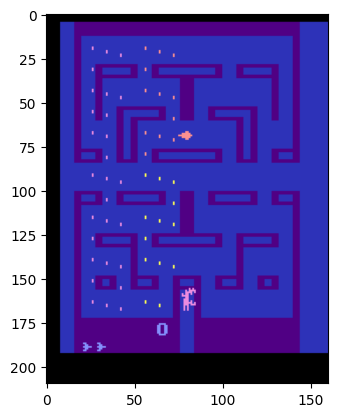

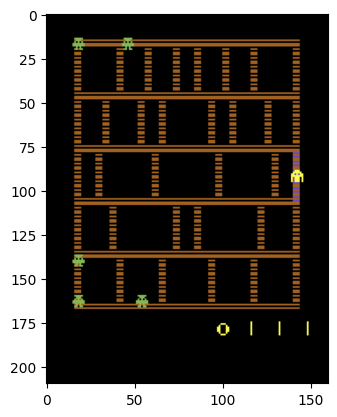

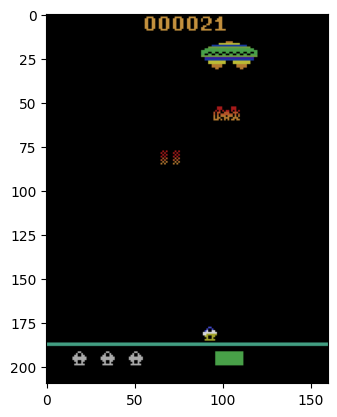

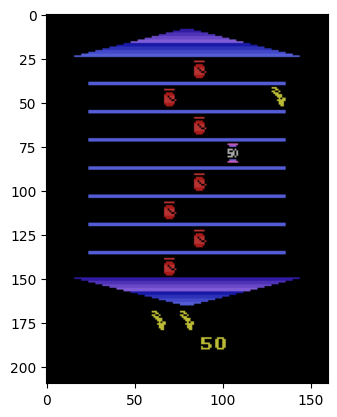

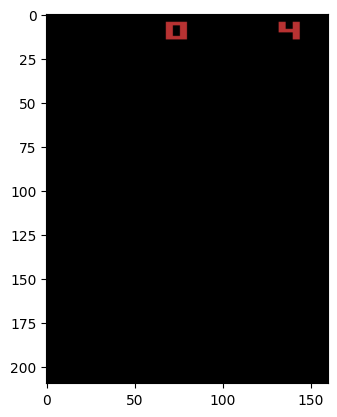

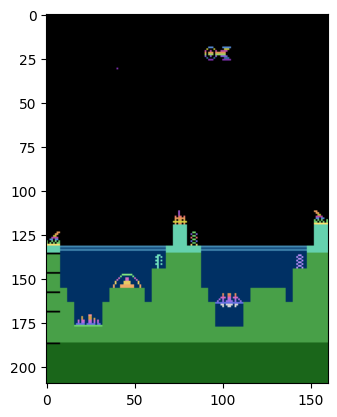

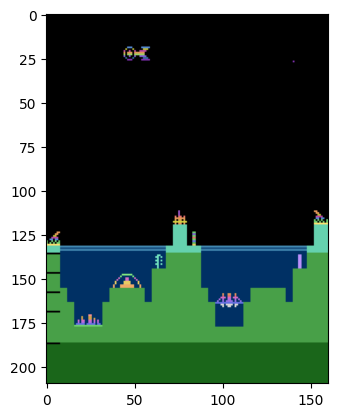

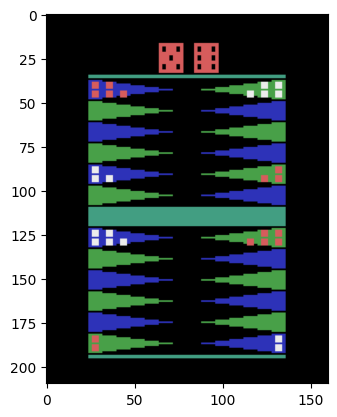

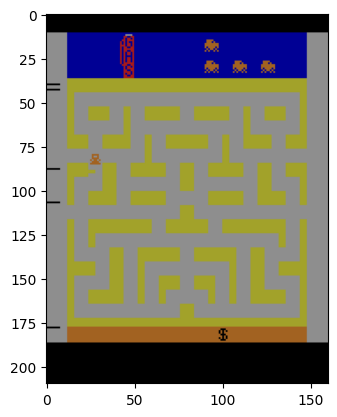

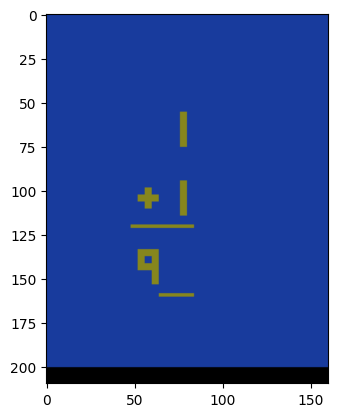

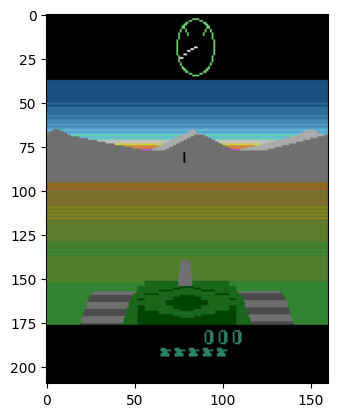

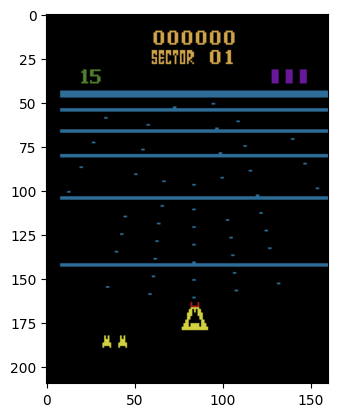

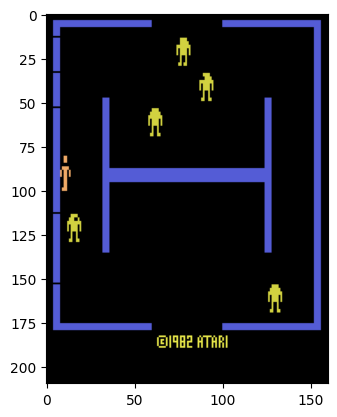

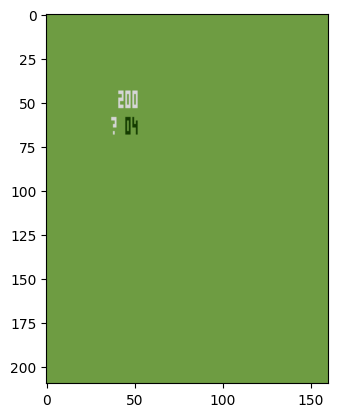

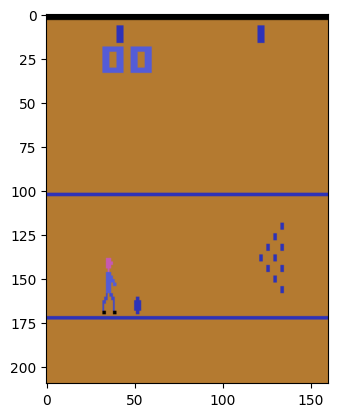

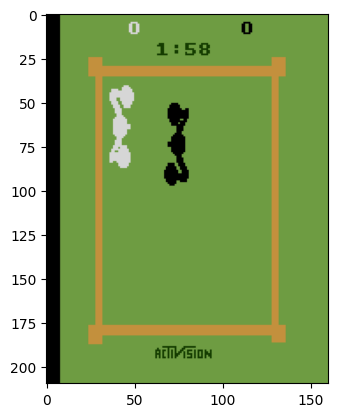

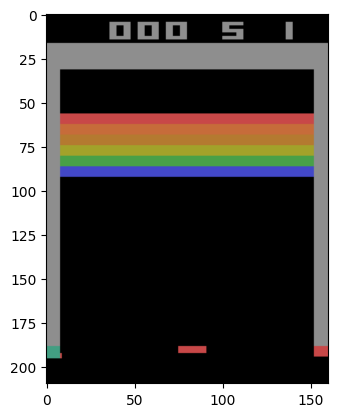

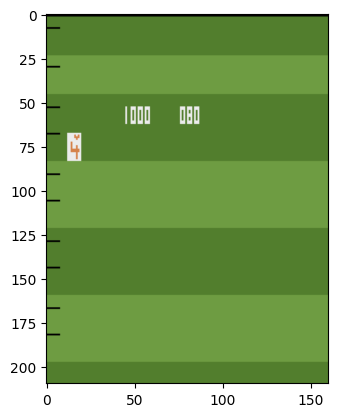

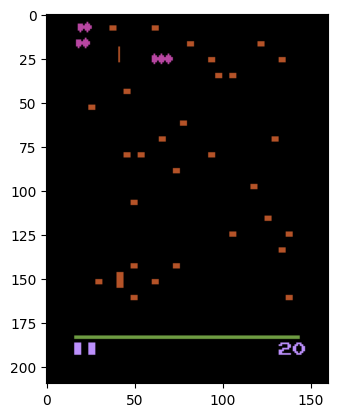

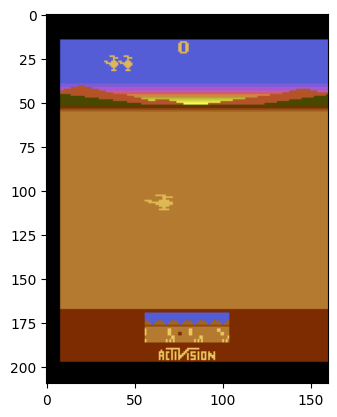

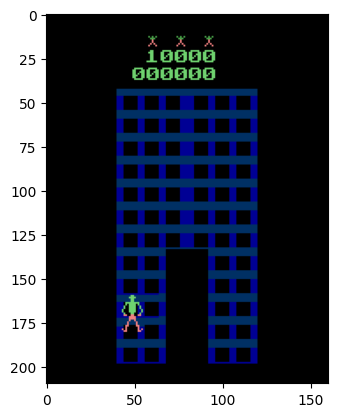

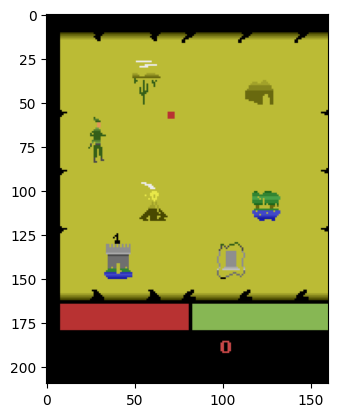

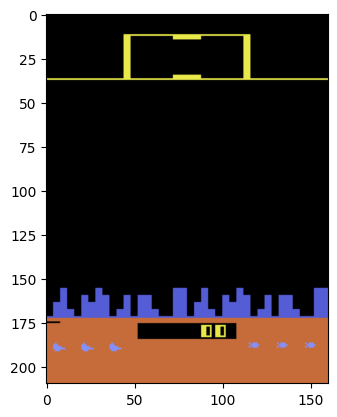

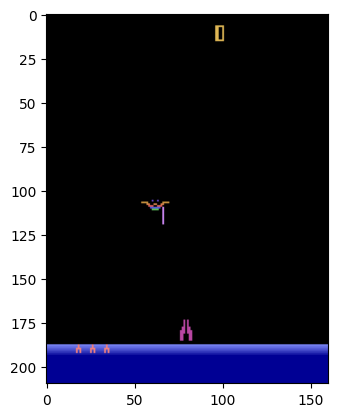

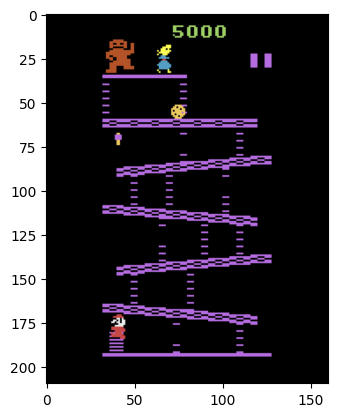

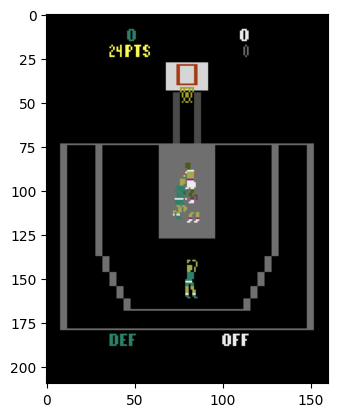

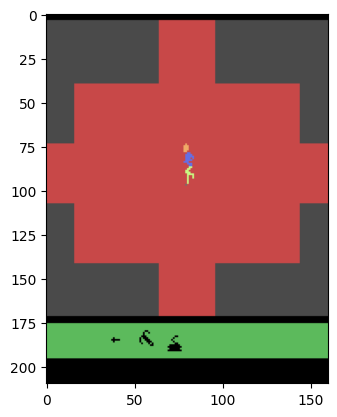

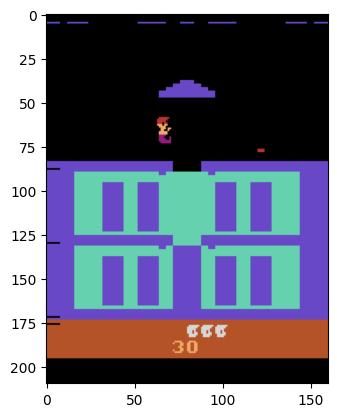

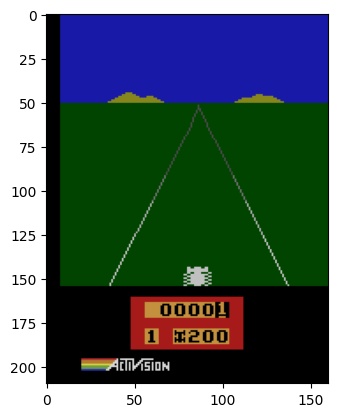

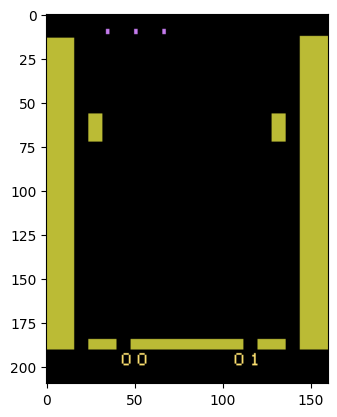

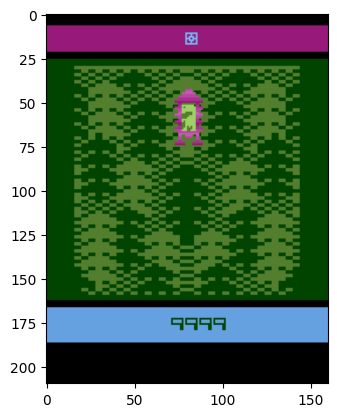

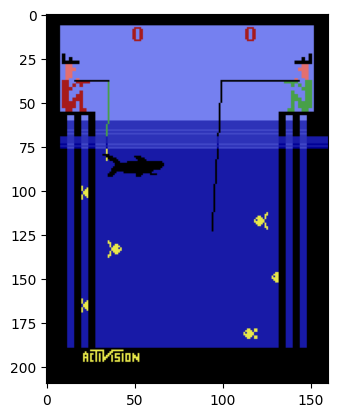

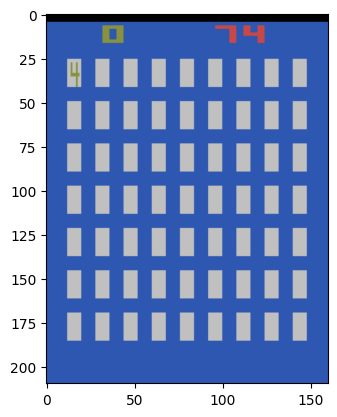

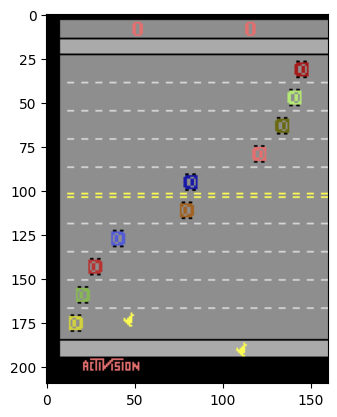

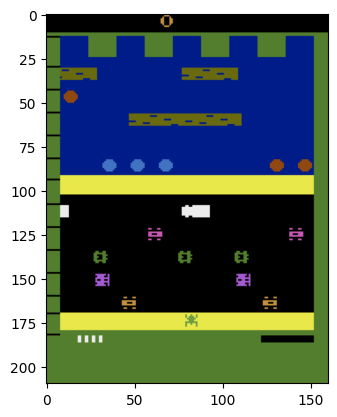

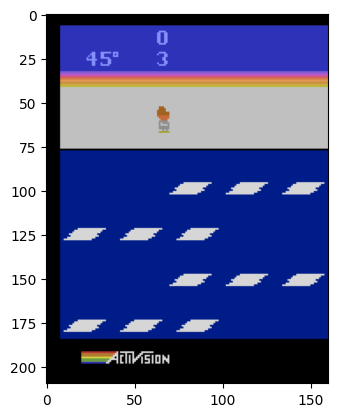

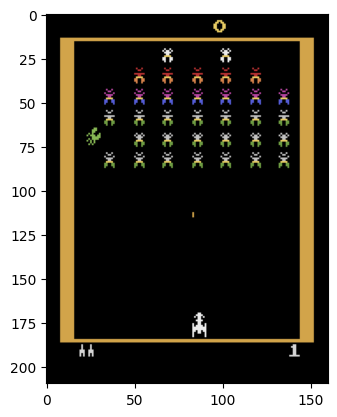

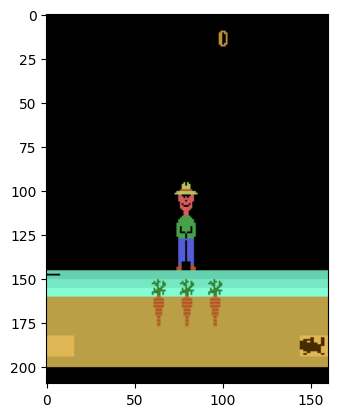

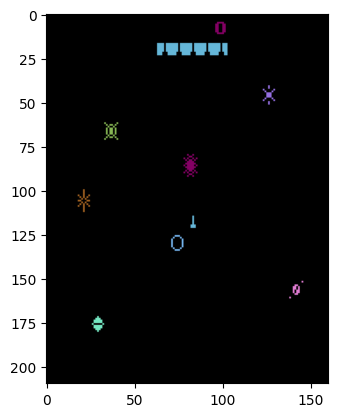

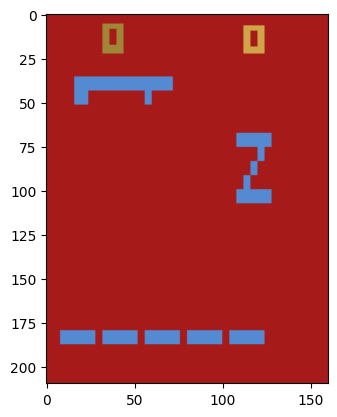

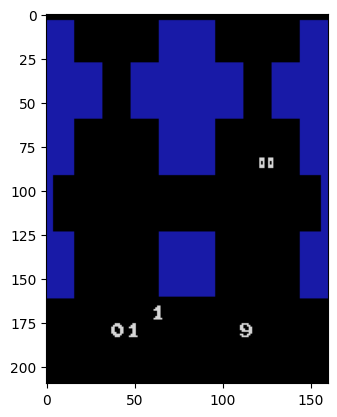

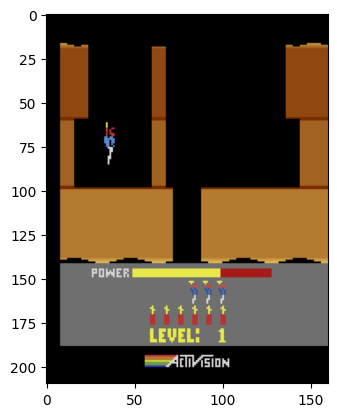

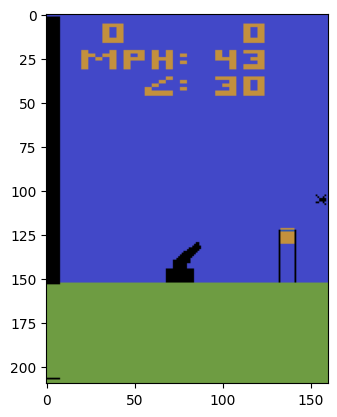

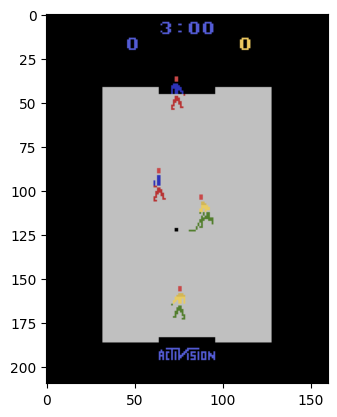

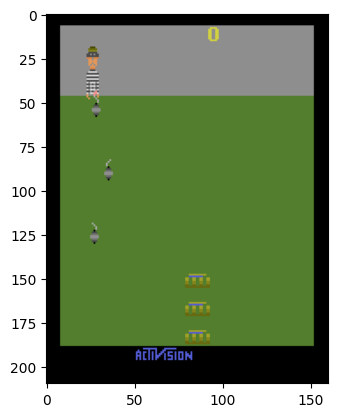

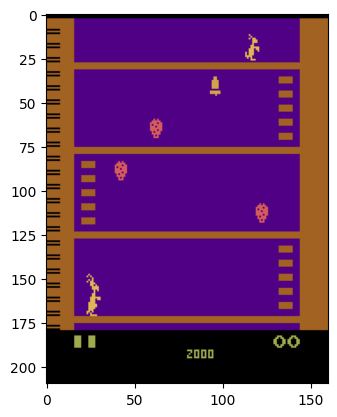

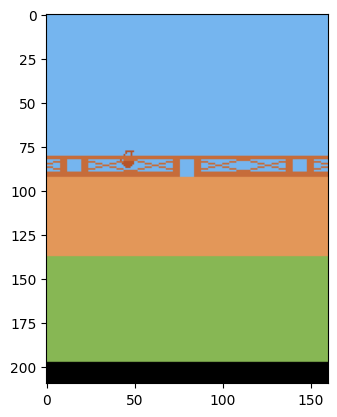

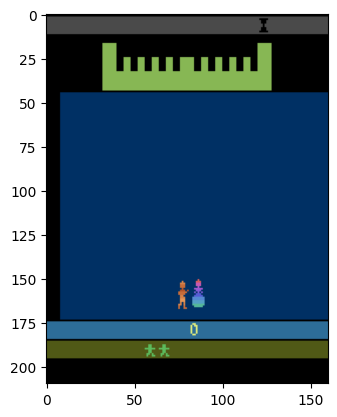

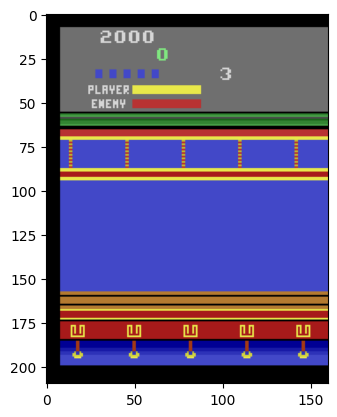

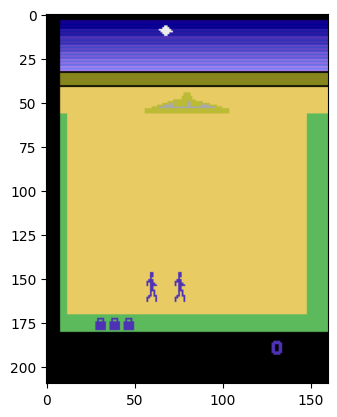

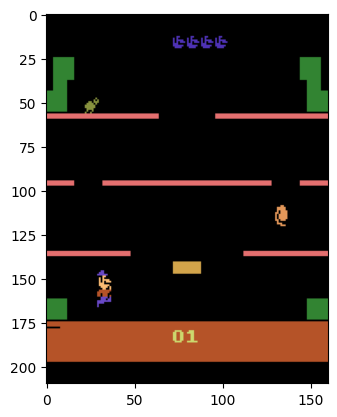

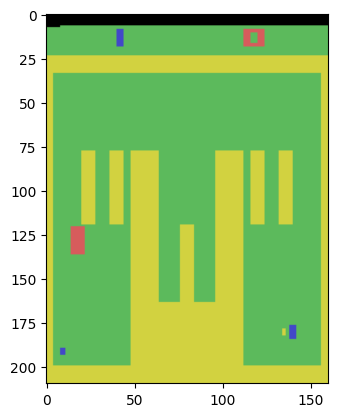

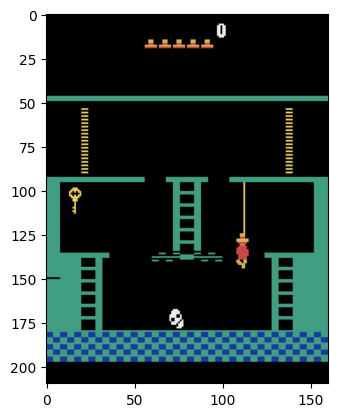

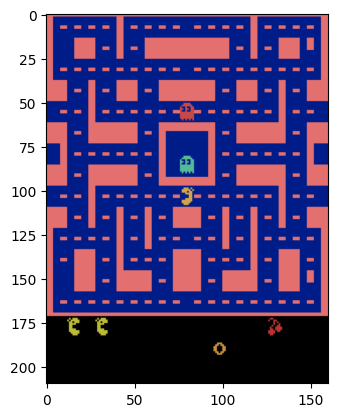

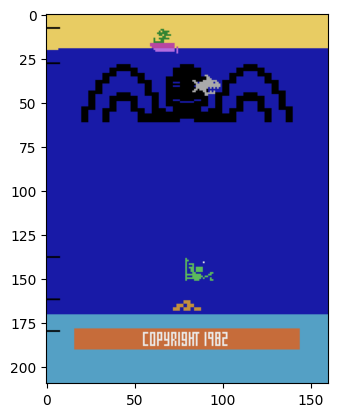

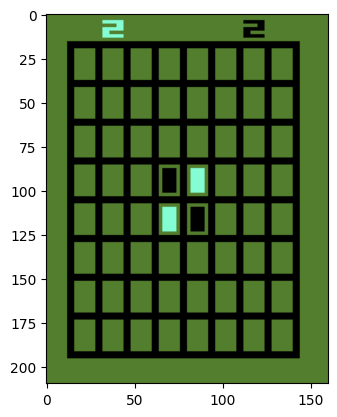

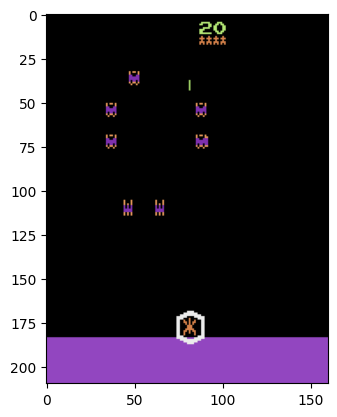

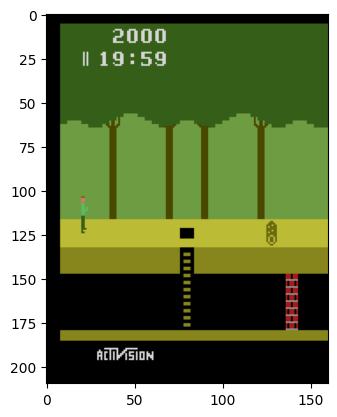

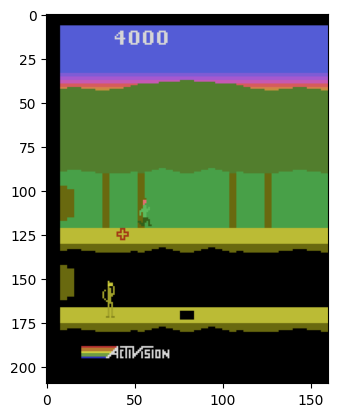

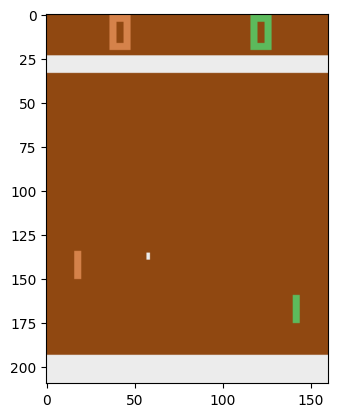

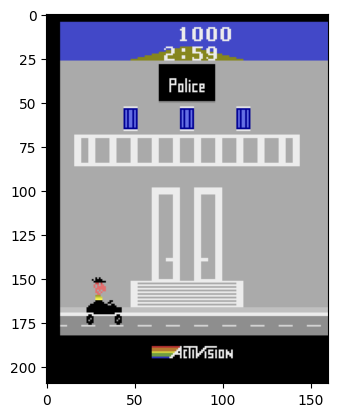

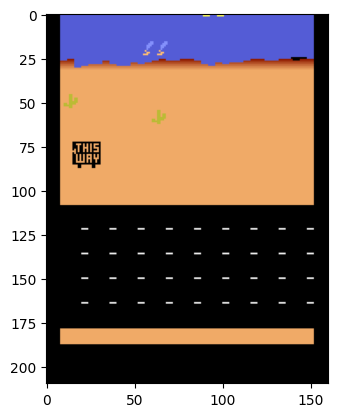

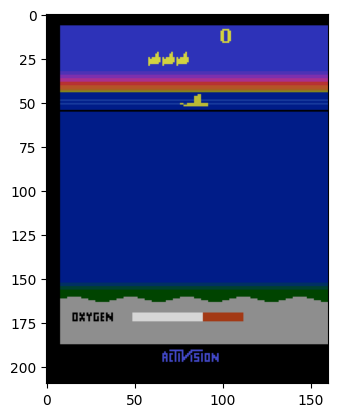

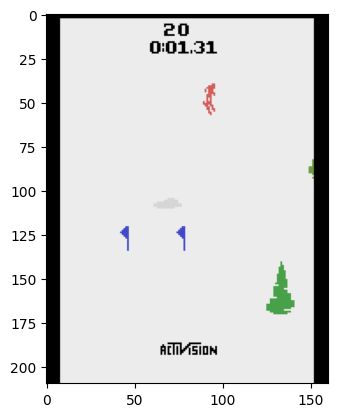

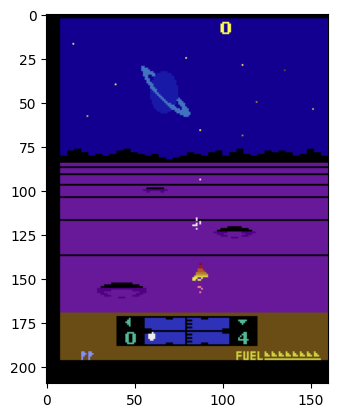

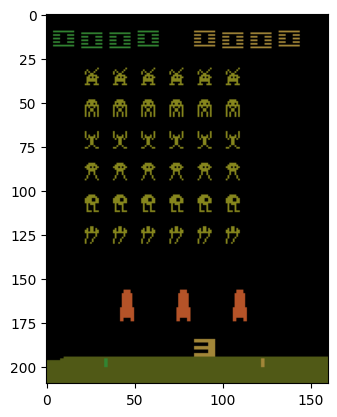

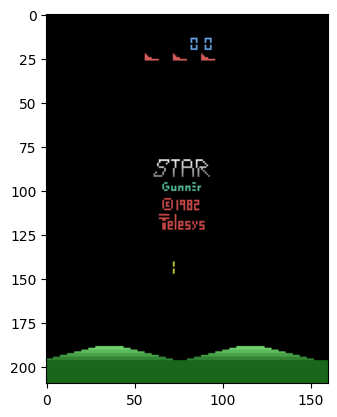

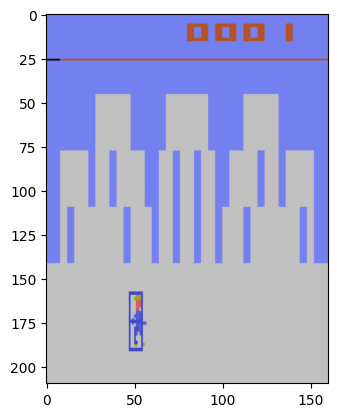

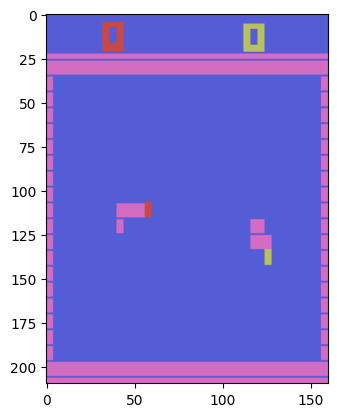

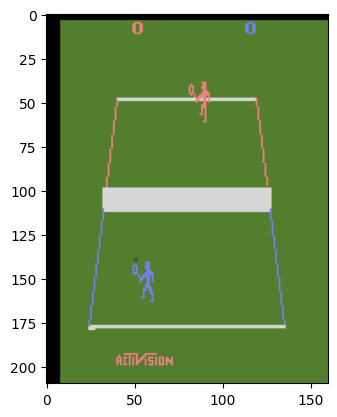

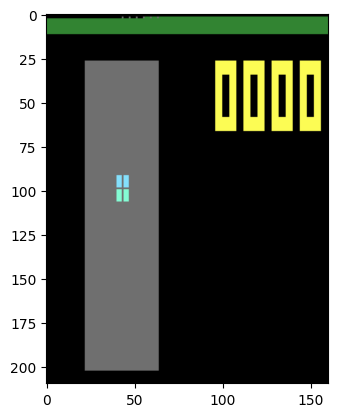

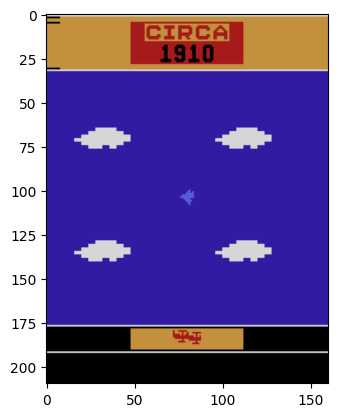

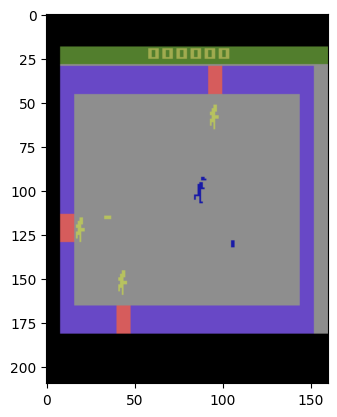

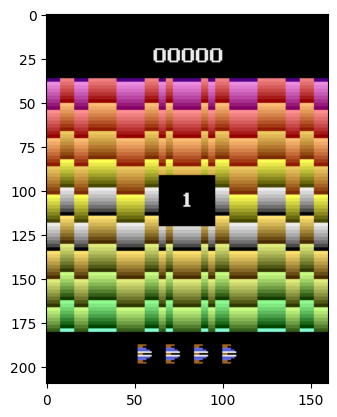

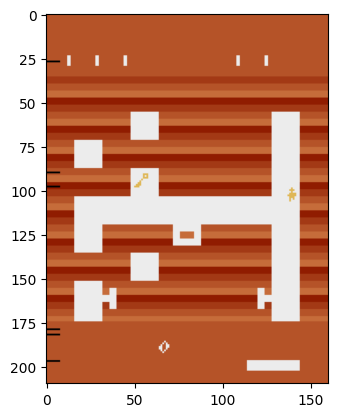

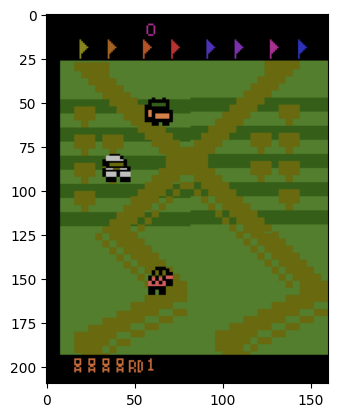

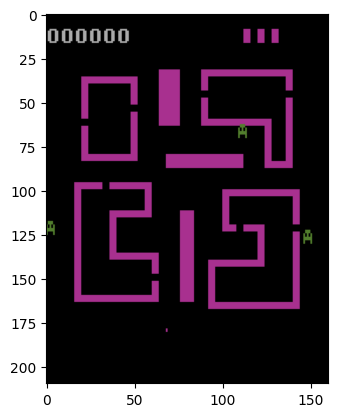

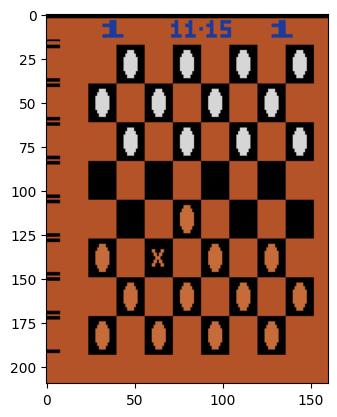

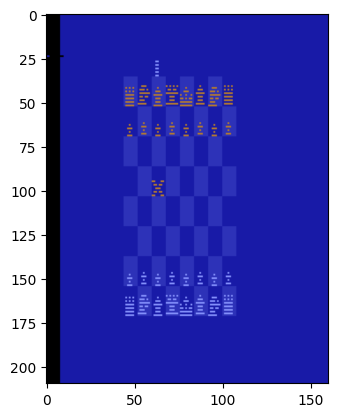

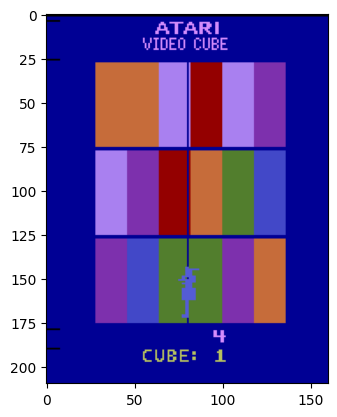

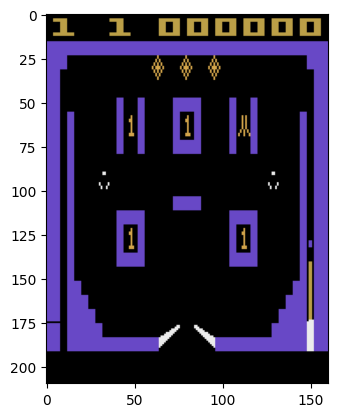

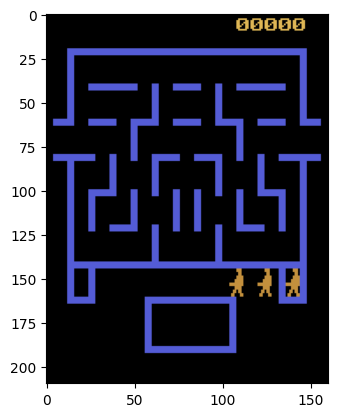

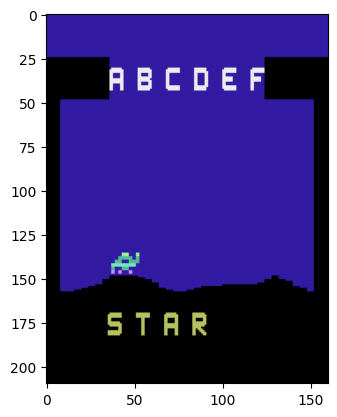

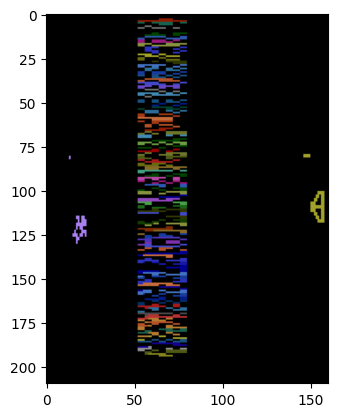

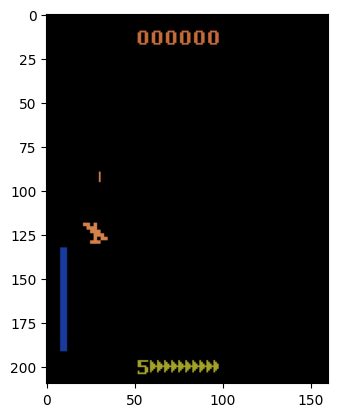

In [7]:
input_shape = (210, 160, 3)
exclude_env = []
observation = None
for env_name, env in envs.items():
    observation, _ = env.reset(seed=seed)
    if observation.shape != input_shape:
        exclude_env.append(env_name)
        continue
    for i in range(20):
        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            observation, info = env.reset()
    plt.imshow(observation)
    plt.show()

for env_name in exclude_env:
    del envs[env_name]

In [8]:
len(envs)

85

In [9]:
all_names = '_'.join(
    [name.split('/')[-1].split('-')[0][:3] for name in envs.keys()]
)
all_names = f'Atari_{len(envs.keys())}_games'
all_names

'Atari_85_games'

In [10]:
from skimage.transform import rescale, resize, downscale_local_mean

def resize_frame(frame):
    image_resized = downscale_local_mean(frame, (6, 4, 1))
    return image_resized.astype(int)
    
image_downscaled = resize_frame(observation)
input_shape = image_downscaled.shape
input_shape

(35, 40, 3)

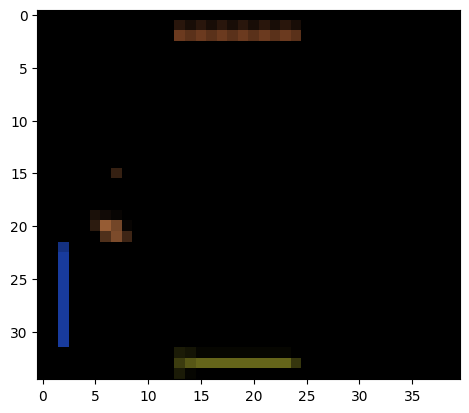

In [11]:
plt.imshow(image_downscaled)

In [12]:
from joblib import Parallel, delayed
import numpy as np
import gc
import itertools

encoder_alpha = 0.4
N = 1000 * len(envs)

def preprocess_images(images, mean, std):
    return (images - mean) / std

def preprocess_images_back(images, mean, std):
    return images * std + mean

def build_dataset_env(env, N, alpha):
    t_max = N
    buf = []
    total_frames = 0
    while total_frames < N:
        (observation, _) = env.reset()
        observation = resize_frame(observation)
        delta = np.zeros(observation.shape)
        for t in range(t_max):
            prev_observation = observation
            action = env.action_space.sample()
            observation, r, done, is_truncated, i = env.step(action)
            # rescale observation to half its size by selecting every other pixel
            observation = resize_frame(observation)
            delta_now = observation / 255.0 - prev_observation / 255.0
            delta = alpha * delta_now + (1 - alpha) * delta
            if t > 1:
                buf.append(delta)
                total_frames += 1
                if total_frames >= N:
                    break
            
            if done:
                break
    return buf

def build_dataset(envs, N, alpha, preprocess_mean=None, preprocess_std=None):
    # Using joblib to parallelize
    build_dataset_env(env, N // len(envs), alpha)
    
    results = Parallel(n_jobs=-1)(
        delayed(build_dataset_env)(env, N // len(envs), alpha) 
        for env in envs.values()
    )
    
    images = np.array(list(itertools.chain.from_iterable(results)))
    del results
    gc.collect()

    if preprocess_mean is None:
        preprocess_mean = np.mean(images)
    if preprocess_std is None:
        preprocess_std = np.std(images)
        
    images_normalized = preprocess_images(images, preprocess_mean, preprocess_std)
    del images 
    gc.collect()
    return images_normalized, preprocess_mean, preprocess_std

In [13]:
print(N)

85000


In [14]:
X, preprocess_mean, preprocess_std = build_dataset(envs, N, encoder_alpha)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53

In [15]:
import torch
from torch import nn

class Autoencoder(nn.Module):
    conv_num_filters = 64
    filter_size = 3
    pool_size = 2
    encode_size = 128
    dense_mid_size = 512
    bottleneck_size = (4, 5)
    def __init__(self, debug=False):
        super(Autoencoder, self).__init__()
        self.debug = debug
        self.encoder = nn.Sequential(
            nn.Conv2d(X.shape[-1], self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(self.pool_size, self.pool_size),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(self.pool_size, self.pool_size),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(self.pool_size, self.pool_size),
            nn.Flatten(),
            nn.Linear(self.conv_num_filters * self.bottleneck_size[0] * self.bottleneck_size[1], self.dense_mid_size),
            nn.ReLU(True),
            nn.Linear(self.dense_mid_size, self.encode_size),
            nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.encode_size, self.dense_mid_size),
            nn.ReLU(True),
            nn.Linear(self.dense_mid_size, self.conv_num_filters * self.bottleneck_size[0] * self.bottleneck_size[1]),
            nn.ReLU(True),
            nn.Unflatten(1, (self.conv_num_filters, self.bottleneck_size[0], self.bottleneck_size[1])),
            nn.Upsample(scale_factor=self.pool_size, mode='nearest'),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=self.pool_size, mode='nearest'),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=(2, 1)),
            nn.ConstantPad2d((0, 0, -1, 0), 0),
            nn.ReLU(True),
            nn.Upsample(scale_factor=self.pool_size, mode='nearest'),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=(2, 1)),
            nn.ConstantPad2d((0, 0, -1, 0), 0),
            nn.ReLU(True),
            nn.Conv2d(self.conv_num_filters, X.shape[-1], self.filter_size, padding=1),
        )

    def forward(self, x):
        x = x.movedim(-1, 1)
        for layer in self.encoder.children():
            x = layer(x)
            if self.debug:
                print(x.shape)
        for layer in self.decoder.children():
            x = layer(x)
            if self.debug:
                print(x.shape)
        x = x.movedim(1, -1)
        return x

In [16]:
import torch.optim as optim
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [17]:
def train_model(model, optimizer, X, device, epochs=50, batch_size=512, num_workers=0):
    # Convert input and output data to tensors and move to device
    X_tensor = torch.from_numpy(X).float().to(device)

    # Create a TensorDataset from input and output tensors
    dataset = TensorDataset(X_tensor)
    
    # Define loss function
    criterion = nn.MSELoss()

    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    # Train the model
    model.train()
    loss_all = []
    running_loss = []
    for _ in range(epochs):
        for _, data in enumerate(dataloader, 0):
            # Get inputs and move to device
            inputs = data[0].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, inputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss.append(loss.item())
            loss_all.append(loss.item())
            if len(running_loss) >= 500:
                print('average loss: %.3f' % np.mean(running_loss))
                running_loss = []
    if len(running_loss) > 0:
        print('average loss: %.3f' % np.mean(running_loss))

    return np.mean(loss_all)

In [18]:
import random
from IPython.display import clear_output

def plot_random(X, count=5):
    clear_output(wait=True)
    images = []
    model.eval()
    for i in range(count):
        # Select a random sample from X
        sample_index = random.randint(0, len(X) - 1)
        sample = X[sample_index].copy()

        # Convert the sample to a tensor and move to device
        sample_tensor = torch.from_numpy(sample).float().unsqueeze(0).to(device)
        decoded = model(sample_tensor)
        # Convert the decoded sample to a numpy array and move to CPU
        decoded_array = decoded.detach().cpu().numpy()[0]

        def calibrate_image(image):
            value_min = image.min()
            value_max = image.max()
            print(value_min, value_max)
            return (image - value_min) / (value_max - value_min)
        
        sample = calibrate_image(sample)
        decoded_array = calibrate_image(decoded_array)
        images.append(sample)
        images.append(decoded_array)
        
    f, axarr = plt.subplots(2, len(images) // 2, figsize=(20, 8))
    for i, image in enumerate(images):
        axarr[i % 2, i // 2].imshow(image)
        axarr[i % 2, i // 2].axis('off')
    plt.tight_layout()
    plt.show()


In [19]:
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available
model = Autoencoder(debug=False).to(device)

In [20]:
import torch
import numpy as np

need_retrain_model = True
batch_size = 128
sampling_iterations = 1000
epoch_count = 5
total_steps = N * sampling_iterations * epoch_count // batch_size
learning_rate = 1e-4
print(f"total_steps: {total_steps}")

# Define optimizer
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
learning_rate_schedule = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
i = 0

total_steps: 3320312


In [21]:
weights_name = f"{all_names}_autoencoder_{encoder_alpha}.state_dict"
# model.load_state_dict(torch.load(weights_name))
print(weights_name)

Atari_85_games_autoencoder_0.4.state_dict


In [22]:
loss_log = []

In [23]:
import seaborn
seaborn.set()

In [24]:
import joblib

joblib.dump({'preprocess_mean': preprocess_mean, 'preprocess_std': preprocess_std}, 'preprocess_constants.joblib')

['preprocess_constants.joblib']

-2.570891458794321 1.094244315764696
-1.6933826 0.3376424
-7.684659955699947 11.853165728996983
-4.9462366 12.071783
-0.9078215838581954 1.4549868437199134
-0.21384765 0.47059998
-3.269489884994287 3.1029133779634375
-1.726174 1.3022162
-10.12339714559929 10.119243708040592
-7.0674505 8.431364


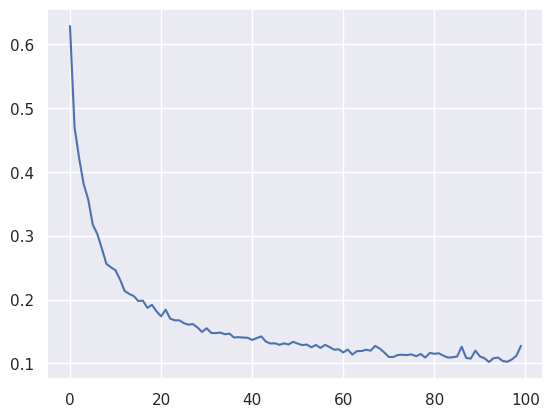

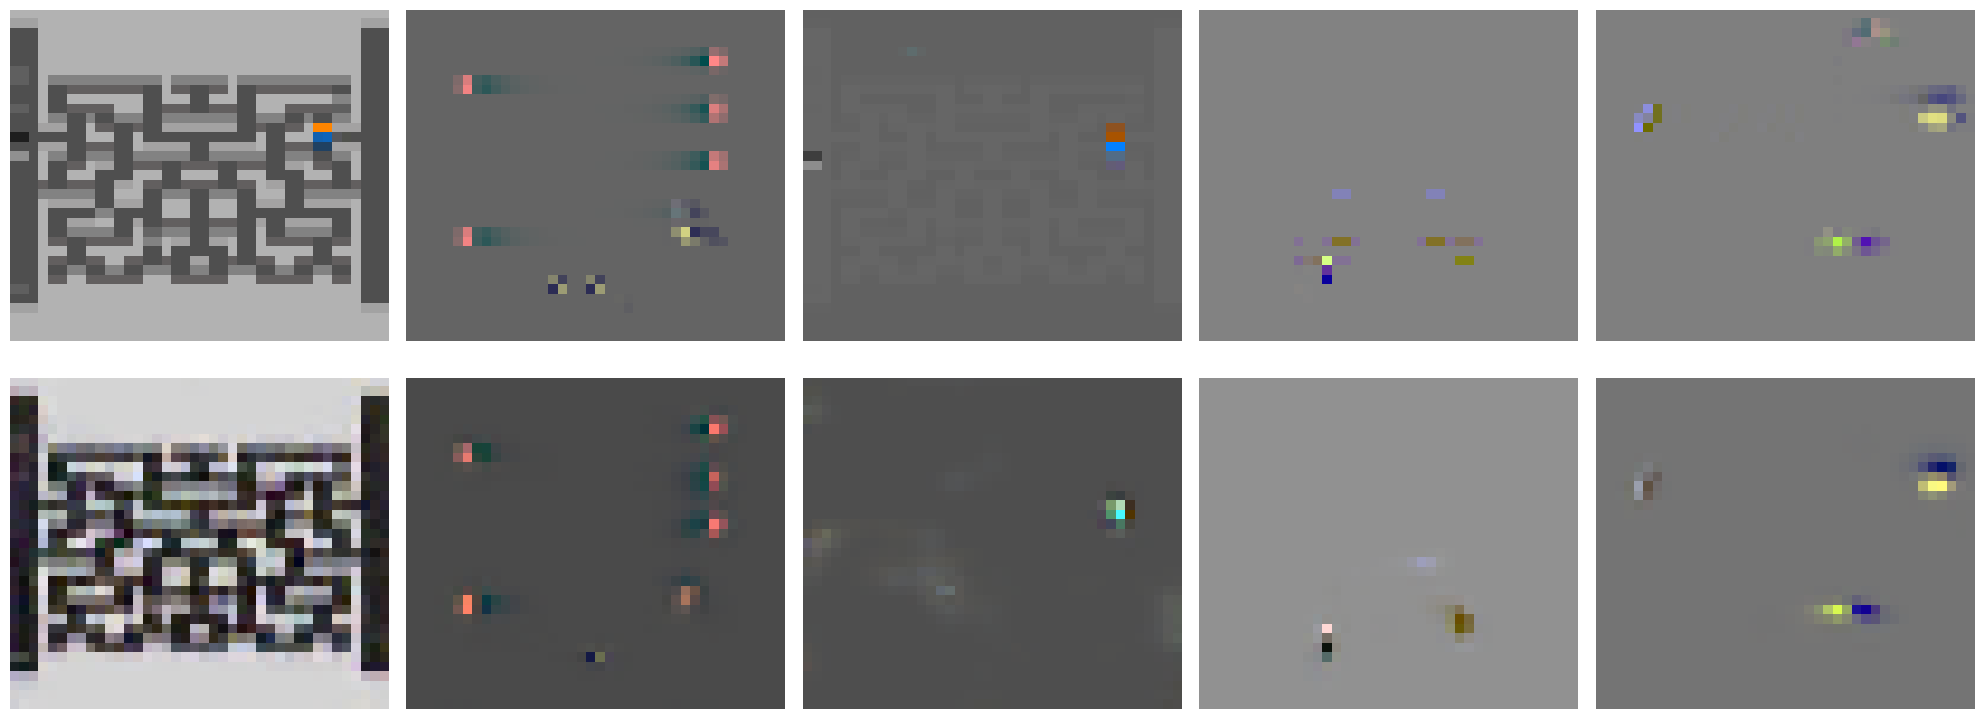

iteration: 110
average loss: 0.115
average loss: 0.111
average loss: 0.110
average loss: 0.110
average loss: 0.107
average loss: 0.107
average loss: 0.108
average loss: 0.108
average loss: 0.106
average loss: 0.102
average loss: 0.103
average loss: 0.101
average loss: 0.103
average loss: 0.100
average loss: 0.106
average loss: 0.104
average loss: 0.102
average loss: 0.102
average loss: 0.100


In [ ]:
if need_retrain_model:
    torch.save(model.state_dict(), weights_name)
    for _ in range(sampling_iterations):
        X, _, _ = build_dataset(envs, N, encoder_alpha, preprocess_mean=preprocess_mean, preprocess_std=preprocess_std)
        if i % 10 == 0 or i < 100:
            plot_random(X)
            plt.plot(loss_log[-100:])
            print(f"iteration: {i}")
        loss_log.append(
            train_model(model, optimizer, X, device, epochs=epoch_count, batch_size=batch_size)
        )
        torch.save(model.state_dict(), weights_name)
        learning_rate_schedule.step()
        del X
        gc.collect()
        i += 1
else:
    model.load_state_dict(torch.load(weights_name))

In [30]:
torch.save(model.state_dict(), weights_name)

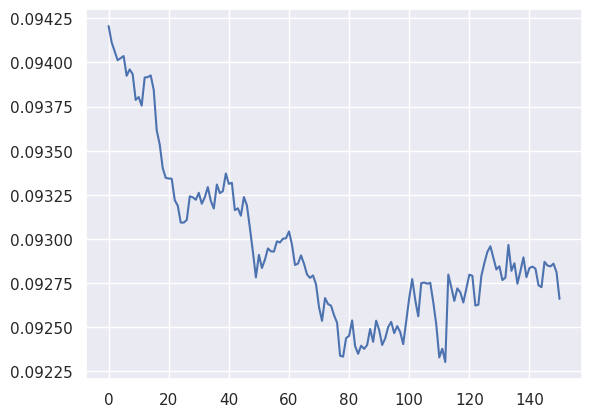

In [28]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(loss_log[-200:], 50))


In [29]:
import joblib

joblib.dump({'preprocess_mean': preprocess_mean, 'preprocess_std': preprocess_std}, 'preprocess_constants.joblib')

['preprocess_constants.joblib']